# xarray-dask and yt : constructing a test case


This notebook walks through the process of loading in dask-xarray gridded datasets into yt. 

It applies to the case where xarray data is loaded with dask chunks, where each dask chunk covers a sub-section of a 3D grid. It assumes a uniform grid (though the grid spacing need not match in each dimension) and relies on yt's new stream-callables functionality. 

Overview: 

1. Building a test dataset 
2. Loading the test dataset with xarray
3. Loading the test dataset with yt: no chunk alignment
4. Aligning the yt and dask-xarray chunks
5. Limitations

Before getting into it, let's import the necessary modules and spin up a dask client. 

In [1]:
from daxryt import data_handling, chunk_inspector
import numpy as np
from dask.distributed import Client
import yt
from yt.utilities.decompose import decompose_array, get_psize
import xarray as xr
import dask 
import os

# Note that we are going to force the dask schedule to the old behavior, 
# where submitted tasks are processed as they are submitted, minimizing 
# downtime but potentially complicating graph exeuction.
# see this discussion for more: 
#     https://github.com/dask/distributed/discussions/7128
dask.config.set({"distributed.scheduler.worker-saturation": "inf"})

In [2]:
c = Client(n_workers=os.cpu_count()-2, threads_per_worker=1)
c

2022-12-12 16:10:20,999 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-bm9zjfh6', purging
2022-12-12 16:10:20,999 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-5r4cw8r6', purging
2022-12-12 16:10:20,999 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-11ffo9jl', purging
2022-12-12 16:10:20,999 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-cuq0g36g', purging
2022-12-12 16:10:21,000 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-dr6ocah8', purging
2022-12-12 16:10:21,000 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-0rko4t2x', purging


<Client: 'tcp://127.0.0.1:38181' processes=6 threads=6, memory=30.94 GiB>

# 1. building a multi-file on-disk test dataset

The following function will create a multi-file netcdf dataset in the supplied directory. Each `.nc` file will be a continuous spatial subset of the global spatial grid. The dataset will be in cartesian coordinates, you can control the size of the dataset by either varying the number of sub-grids in any dimension (`n_grids_xyz`) or by varying the number of cells in each grid (`cells_per_grid_xyz`): 

In [3]:
rebuild_data = False  # switch to True for first run
test_case = 'large_ish_10Gbish'  # choose one from below

test_cases = {
    'large_ish_10Gbish': {'n_grids_xyz': (10, 10, 10),   
                          'grid_wids_xyz': np.array([1., 1., 1.]),
                          'cells_per_grid_xyz': (121, 121, 121),
                          'output_dir': "data"},
    'small': {'n_grids_xyz': (4, 4, 4),   
                    'grid_wids_xyz': np.array([2., 2., 2.]),
                    'cells_per_grid_xyz': (21, 21, 21),
                    'output_dir': "data_small"}, 
}

if rebuild_data:
    data_handling.build_test_data(
        n_grids_xyz=test_cases[test_case]['n_grids_xyz'],
        grid_wids_xyz=test_cases[test_case]['grid_wids_xyz'],
        cells_per_grid_xyz=test_cases[test_case]['cells_per_grid_xyz'],
        output_dir=test_cases[test_case]['output_dir'],
        clear_output_dir=True, 
        dask_client=c,
    )

# 2. Loading the test dataset with xarray 

when you use `xr_open_mfdataset('directory/*.nc')`, xarray will load the whole directory with dask, with each file corresponding to a dask chunk:

In [4]:
ds_xr = xr.open_mfdataset(os.path.join(test_cases[test_case]['output_dir'], "*.nc"))

In [5]:
ds_xr.temperature

<xarray.DataArray 'temperature' (x: 1210, y: 1210, z: 1210)>
dask.array<concatenate, shape=(1210, 1210, 1210), dtype=float64, chunksize=(121, 121, 121), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 0.004132 0.0124 0.02066 0.02893 ... 9.979 9.988 9.996
  * y        (y) float64 0.004132 0.0124 0.02066 0.02893 ... 9.979 9.988 9.996
  * z        (z) float64 0.004132 0.0124 0.02066 0.02893 ... 9.979 9.988 9.996

The test dataset has a number of fields:

In [6]:
print(ds_xr.data_vars)

Data variables:
    temperature  (x, y, z) float64 dask.array<chunksize=(121, 121, 121), meta=np.ndarray>
    gauss        (x, y, z) float64 dask.array<chunksize=(121, 121, 121), meta=np.ndarray>
    xvals        (x, y, z) float64 dask.array<chunksize=(121, 121, 121), meta=np.ndarray>
    yvals        (x, y, z) float64 dask.array<chunksize=(121, 121, 121), meta=np.ndarray>
    zvals        (x, y, z) float64 dask.array<chunksize=(121, 121, 121), meta=np.ndarray>


The `xvals` , `yvals` , `zvals` arrays are the x,y,z value of each point. These are not needed, as xarray will always store the 1d coordinate arrays in memory, but they are useful in this test case to make sure the grids are being reconstructed properly. 

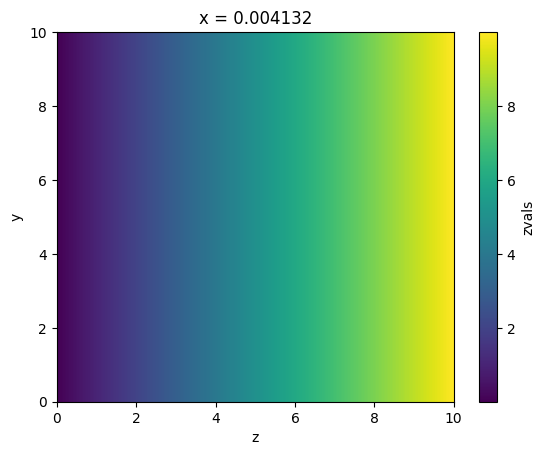

In [7]:
zvals_at_x0 = ds_xr.zvals.isel({"x":0})
zvals_at_x0.plot()

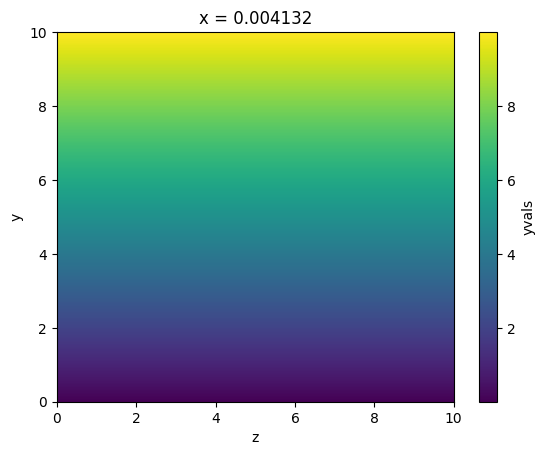

In [8]:
yvals_at_x0 = ds_xr.yvals.isel({"x":0})
yvals_at_x0.plot()

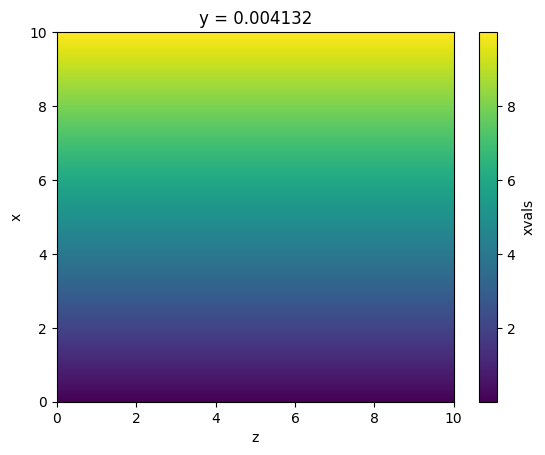

In [9]:
xvals_at_y0 = ds_xr.xvals.isel({"y":0})
xvals_at_y0.plot()

The other two fields are a random variable:

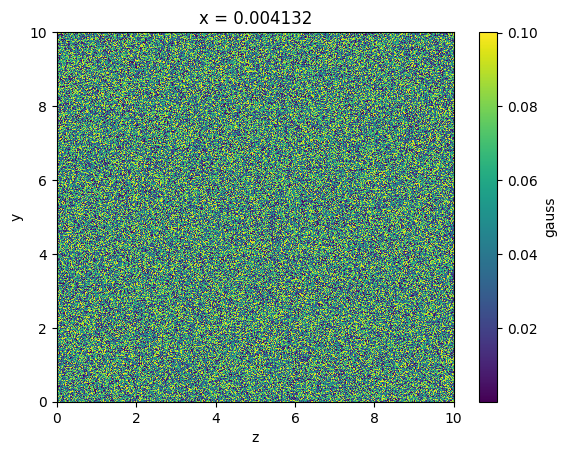

In [10]:
T_at_x = ds_xr.gauss.isel({"x":0})
T_at_x.plot()

and a gaussian field with random noise centered at (x,y,z) = (3,3,3), which again is a nice way to make sure our grids are reconstructing as expected:

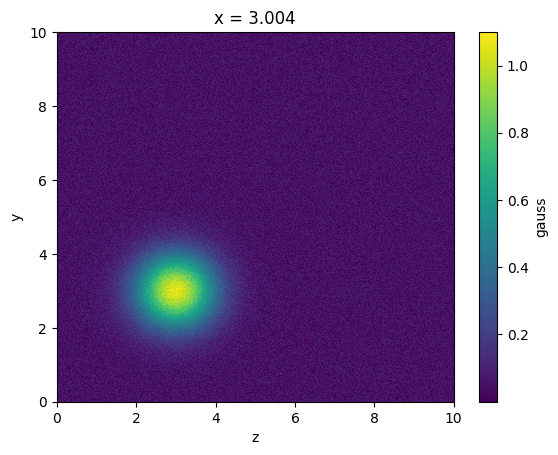

In [11]:
gauss_at_x0 = ds_xr.gauss.sel({"x":3}, method='nearest')
gauss_at_x0.plot()

# 3. loading in yt: no grid alignment

We're now ready to load into yt!

First off, we will not worry about how the yt grid decomposition aligns with the dask chunks. Meaning that given our dask array: 


In [12]:
ds_xr.xvals

<xarray.DataArray 'xvals' (x: 1210, y: 1210, z: 1210)>
dask.array<concatenate, shape=(1210, 1210, 1210), dtype=float64, chunksize=(121, 121, 121), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 0.004132 0.0124 0.02066 0.02893 ... 9.979 9.988 9.996
  * y        (y) float64 0.004132 0.0124 0.02066 0.02893 ... 9.979 9.988 9.996
  * z        (z) float64 0.004132 0.0124 0.02066 0.02893 ... 9.979 9.988 9.996

we will not try to match our yt grid to the dask chunks. We will use yt's standard grid decomposition functions `get_psize` and `decompose_array` to split up the domain. This means that when yt reads data, each yt grid object may contain multiple dask chunks. 

First, let's define our yt data reader. This function is the callable that will return data as needed. It relies on having our open xarray handle, so there may be some tricky parallelization considerations, but as the yt grid chunking procedure will access chunks sequentially, we will be OK for now:

In [13]:
def _read_data(handle):
    def _reader(grid, field_name):
        ftype, fname = field_name
        si = grid.get_global_startindex()
        ei = si + grid.ActiveDimensions
        var = getattr(handle, fname)  # variables are top-level attrs of xr datasets        
        data = var[si[0] : ei[0], si[1] : ei[1], si[2] : ei[2]]
        return data.values

    return _reader


reader = _read_data(ds_xr)

Now let's decide what fields to pass to our yt dataset and also do the grid decomposition. 

Note that in this example, we are neglecting the fact that our xarray arrays are node-centered values. We're treating the data a cell-centered values but pulling min/max domain limits in x, y and z from the node values. So there's technically a bit of an error there... we'll overcome this in the next section and it's not a noticeable issue for this example. 

In [14]:
fields = list(ds_xr.data_vars)
global_shape = ds_xr.data_vars[fields[0]].shape
global_left = np.array([ds_xr.coords[cn].min() for cn in ds_xr.dims.keys()])
global_right = np.array([ds_xr.coords[cn].max() for cn in ds_xr.dims.keys()])
bbox = np.column_stack([global_left, global_right])


# decompose the grid for yt, ignoring the xarray chunking
n_grid_chunks = 900  # (nprocs in load_uniform_grid)
psize = get_psize(np.array(global_shape), n_grid_chunks)
grid_left_edges, grid_right_edges, grid_shapes, slices = decompose_array(
    global_shape, psize, bbox
)

we're now ready to build the list of grid dictionaries expected by `load_amr_grids`. Note that we're adding on the `level` attribute set to 0 here to denote that our grids do not have any interior refinement -- we're just loading a tile of grids! 

In [15]:

grid_data = []
for gid in range(n_grid_chunks):
    new_grid = {
        "left_edge": grid_left_edges[gid],
        "right_edge": grid_right_edges[gid],            
        "dimensions": grid_shapes[gid],
        "level": 0,
    }
    for field in fields:
        new_grid[field] = reader
        
    grid_data.append(new_grid)
    

ds = yt.load_amr_grids(grid_data, global_shape, bbox=bbox)

yt : [INFO     ] 2022-12-12 16:10:42,411 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-12-12 16:10:42,412 Parameters: domain_dimensions         = [1210 1210 1210]
yt : [INFO     ] 2022-12-12 16:10:42,414 Parameters: domain_left_edge          = [0.00413223 0.00413223 0.00413223]
yt : [INFO     ] 2022-12-12 16:10:42,415 Parameters: domain_right_edge         = [9.99586777 9.99586777 9.99586777]
yt : [INFO     ] 2022-12-12 16:10:42,416 Parameters: cosmological_simulation   = 0


In [16]:
c

<Client: 'tcp://127.0.0.1:38181' processes=6 threads=6, memory=30.94 GiB>

Ok, let's plot some data! If you access the above dashboard link while running the following cells, you should see tasks being distributed to the dask cluster. 

yt : [INFO     ] 2022-12-12 16:10:56,613 xlim = 0.004132 9.995868
yt : [INFO     ] 2022-12-12 16:10:56,615 ylim = 0.004132 9.995868
yt : [INFO     ] 2022-12-12 16:10:56,616 xlim = 0.004132 9.995868
yt : [INFO     ] 2022-12-12 16:10:56,617 ylim = 0.004132 9.995868
yt : [INFO     ] 2022-12-12 16:10:56,622 Making a fixed resolution buffer of (('stream', 'gauss')) 800 by 800



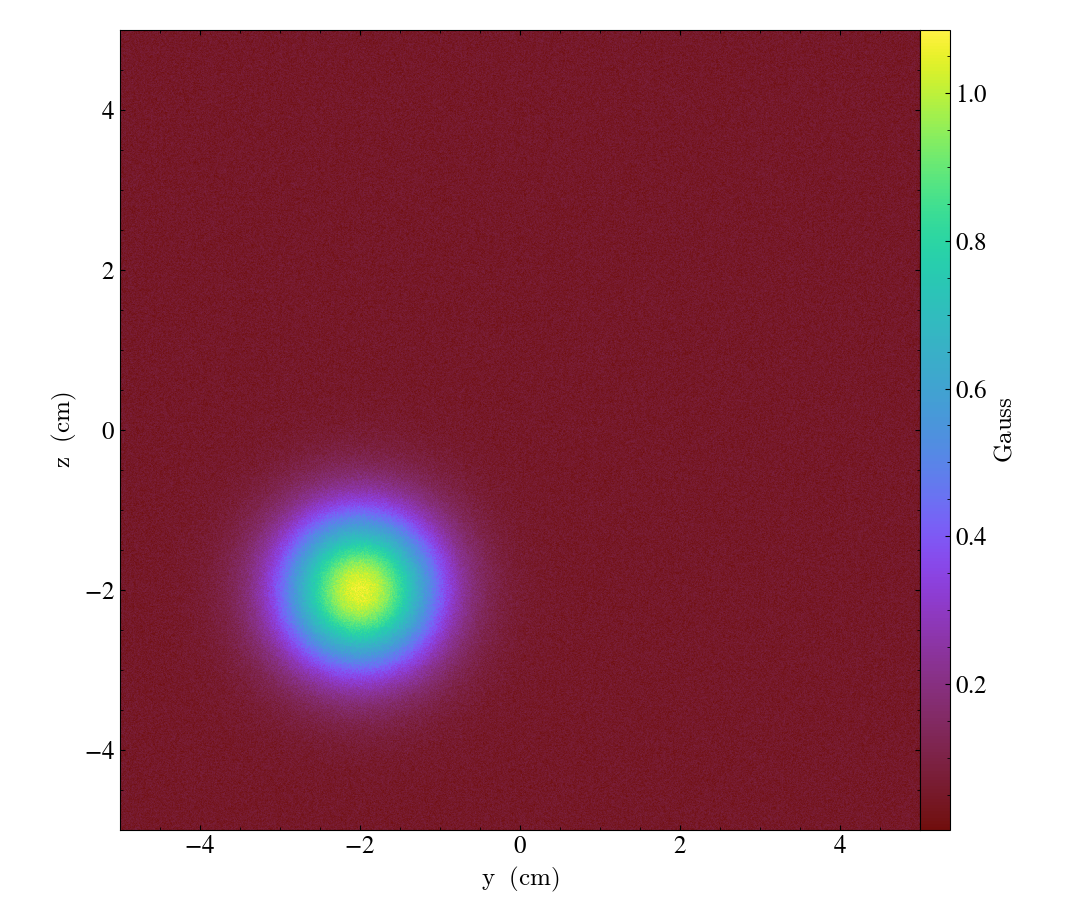

In [17]:
fld = ('stream', "gauss")
ce = ds.domain_center
ce[0] = 3.
slc = yt.SlicePlot(ds, "x", fld, center = ce)
slc.set_log(fld, False)

Let's use a sphere to restrict the yt chunks that get selected

In [18]:
sp = ds.sphere(ds.arr([3.,3.,3.],'code_length'), 2.)
sp.center

unyt_array([3., 3., 3.], 'code_length')

yt : [INFO     ] 2022-12-12 16:11:19,816 xlim = -1.995868 7.995868
yt : [INFO     ] 2022-12-12 16:11:19,817 ylim = -1.995868 7.995868
yt : [INFO     ] 2022-12-12 16:11:19,818 xlim = -1.995868 7.995868
yt : [INFO     ] 2022-12-12 16:11:19,819 ylim = -1.995868 7.995868
yt : [INFO     ] 2022-12-12 16:11:19,823 Making a fixed resolution buffer of (('stream', 'gauss')) 800 by 800



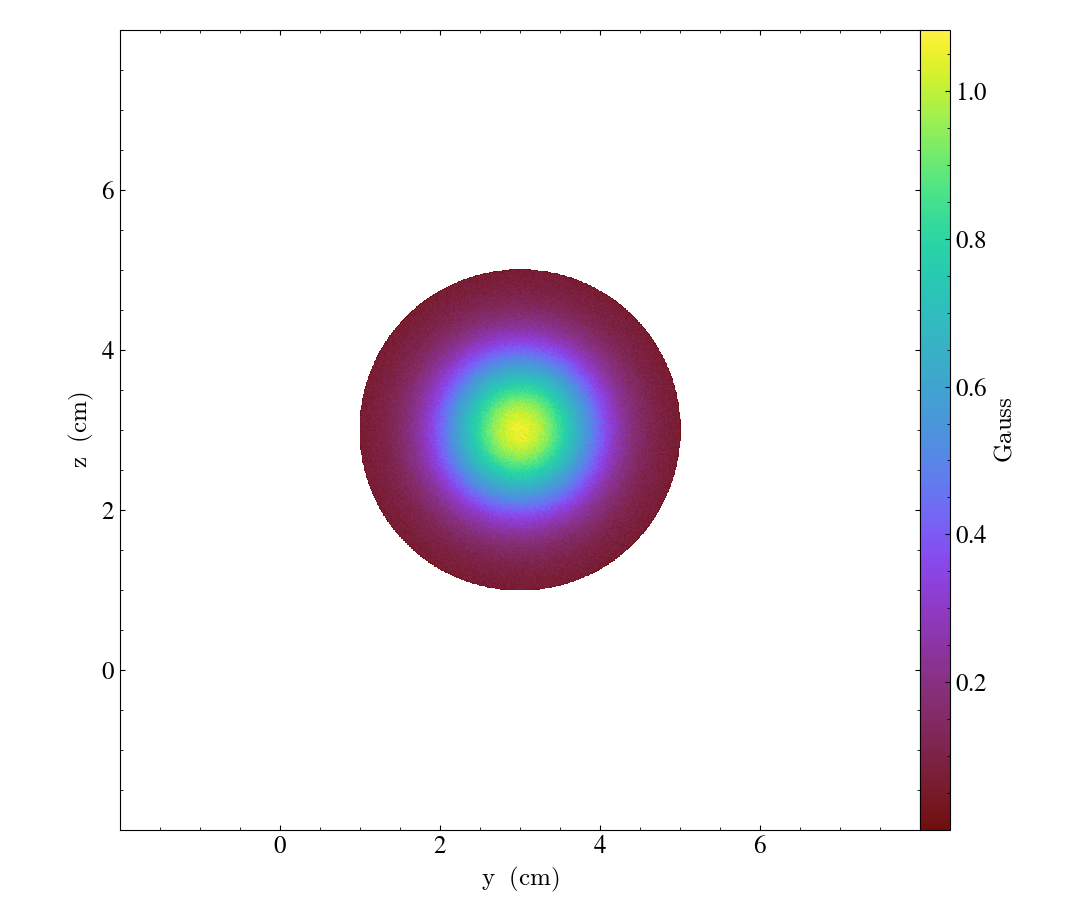

In [19]:
fld = ('stream', "gauss")
slc = yt.SlicePlot(ds, "x", fld, center = sp.center, data_source=sp, origin='native')
slc.set_log(fld, False)

and check that we can calculate some quantities

In [20]:
%%time
sp.quantities.max_location(fld)

CPU times: user 10.1 s, sys: 4.99 s, total: 15.1 s
Wall time: 15.6 s


[unyt_quantity(1.09936532, '(dimensionless)'),
 unyt_quantity(3.00578171, 'code_length'),
 unyt_quantity(3.01403934, 'code_length'),
 unyt_quantity(3.00578171, 'code_length')]

In [21]:
%%time
sp.quantities.total_quantity(fld)

CPU times: user 6.35 s, sys: 812 ms, total: 7.16 s
Wall time: 7.82 s


unyt_quantity(12388892.77341626, '(dimensionless)')

In [22]:
%%time
sp.quantities.extrema(fld)

CPU times: user 5.77 s, sys: 764 ms, total: 6.53 s
Wall time: 7.23 s


unyt_array([0.0180172 , 1.09936532], '(dimensionless)')

PhasePlots are nice:


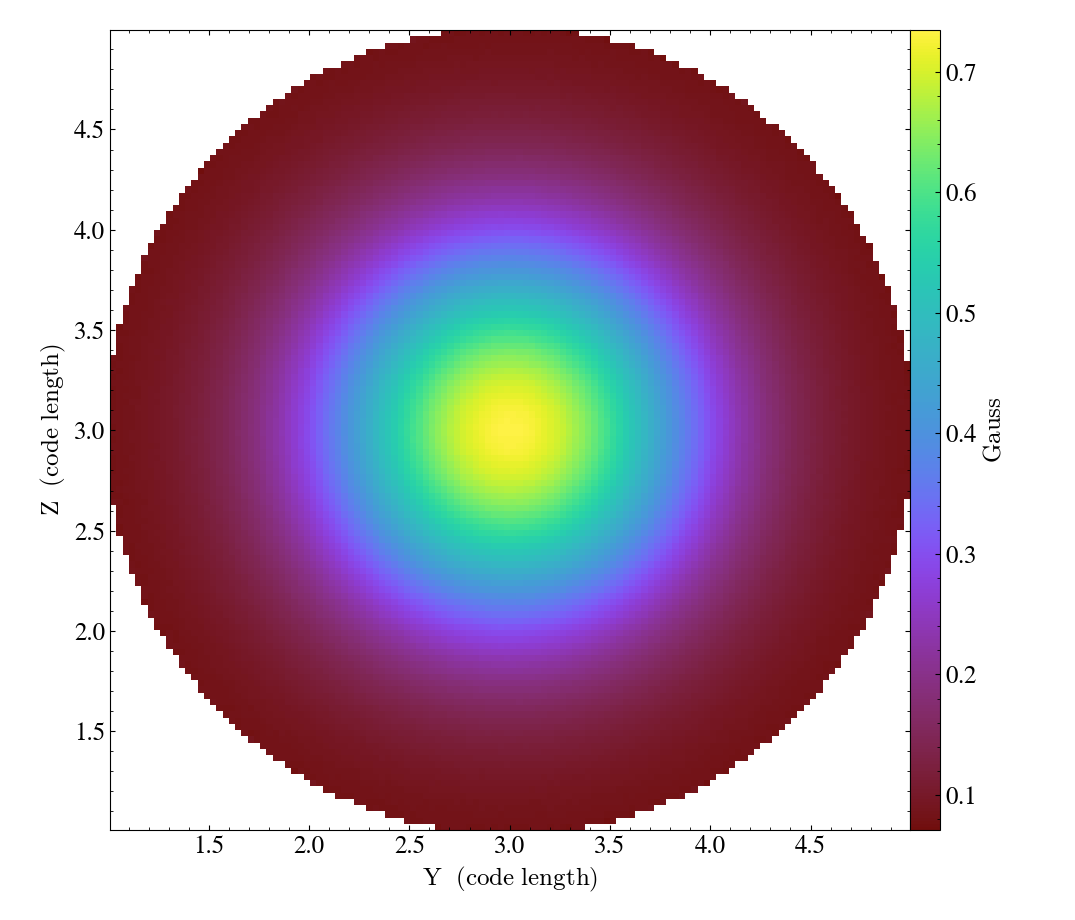

In [23]:
pp = yt.PhasePlot(sp, ("index", "y"), ("index", "z"), fld, weight_field=fld)
pp.set_log(fld, False)


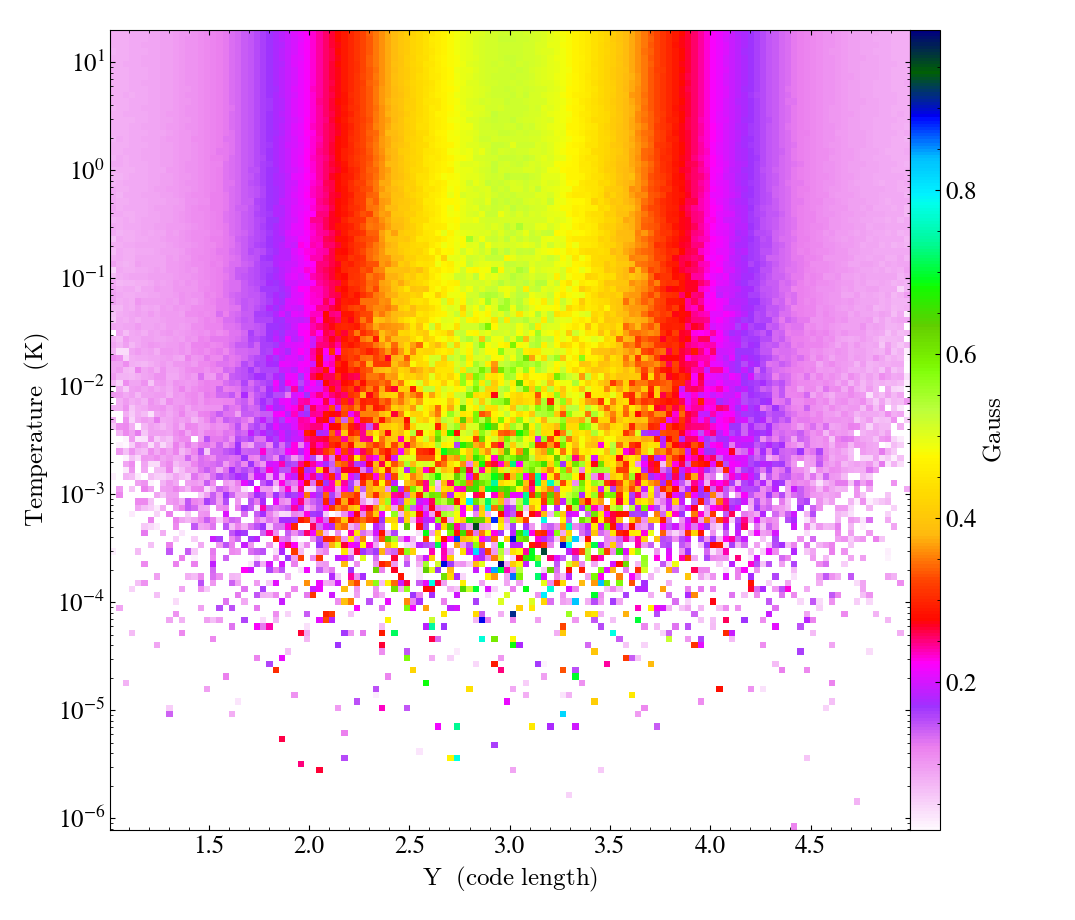

In [24]:
pp = yt.PhasePlot(sp, ("index", "y"), ("stream", "temperature"), fld, weight_field=fld)
pp.set_cmap(fld, "gist_ncar_r")
pp.set_log(fld, False)

# 4. aligning the xarray and yt grids

So the above approach is interesting in that the yt grid objects contain potentially multiple dask chunks. There may be some cases where this is ideal: if the amount data in each chunk is relatively small it may be advantageous to have the yt grid objects load from multiple dask chunks. But for maximum flexibility, we should have a way of specifying the ratio of xarray-dask chunks to yt chunks. 

The obvious starting place is to work out how to exactly align the xarray-dask chunks with the yt grids. Let's get into it...


## chunk inspection 

So dask-xarray datasets and variables will have `chunks` and `chunksizes` attributes:

In [25]:
ds_xr.gauss.chunksizes

Frozen({'x': (121, 121, 121, 121, 121, 121, 121, 121, 121, 121), 'y': (121, 121, 121, 121, 121, 121, 121, 121, 121, 121), 'z': (121, 121, 121, 121, 121, 121, 121, 121, 121, 121)})

In [26]:
ds_xr.gauss.chunks

((121, 121, 121, 121, 121, 121, 121, 121, 121, 121),
 (121, 121, 121, 121, 121, 121, 121, 121, 121, 121),
 (121, 121, 121, 121, 121, 121, 121, 121, 121, 121))

These represent the number of elements in each direction in each chunk. 

In order to align with the yt grids, however, we need to know the physical ranges (the left edge and right edge) of each of these chunks. 

There are two possible approaches here:

The first approach is to rely entirely on in-memory information in the xarray dataset. Even when loading with `open_mfdataset`, the 1d coordinate arrays (`x`, `y`, `z`) will still be in-memory. So as long as we are careful about the array index ordering, we can find the global start and end indices of each chunk then extract the coordinate ranges of each chunk. This assumes continuous ranges of coordinates in each chunk. 

The second approach would be to use something like `map_blocks` to write a function that returns the limits of each dask chunk. There may be situations where this is useful, but since we know the structure of our test data, the first option is better as it avoids an unnecessary read of all the chunks. 

The following class implements a recursive domain walk over an xarray `Dataset` or `DataArray`, storing the start and end indices and coordinate ranges (and some other info) of each dask chunk:

In [27]:
c_w = chunk_inspector.ChunkWalker()

In [28]:
c_w.walk_the_chunks(ds_xr)
c_w.df

si                  ei             size  \
chunk_number                                                            
0                      [0, 0, 0]     [121, 121, 121]  [121, 121, 121]   
1                    [0, 0, 121]     [121, 121, 242]  [121, 121, 121]   
2                    [0, 0, 242]     [121, 121, 363]  [121, 121, 121]   
3                    [0, 0, 363]     [121, 121, 484]  [121, 121, 121]   
4                    [0, 0, 484]     [121, 121, 605]  [121, 121, 121]   
...                          ...                 ...              ...   
995            [1089, 1089, 605]   [1210, 1210, 726]  [121, 121, 121]   
996            [1089, 1089, 726]   [1210, 1210, 847]  [121, 121, 121]   
997            [1089, 1089, 847]   [1210, 1210, 968]  [121, 121, 121]   
998            [1089, 1089, 968]  [1210, 1210, 1089]  [121, 121, 121]   
999           [1089, 1089, 1089]  [1210, 1210, 1210]  [121, 121, 121]   

                                                             le  \
chunk_number                                                      
0             [6.938893903907228e-17, 6.938893903907228e-17,...   
1             [6.938893903907228e-17, 6.938893903907228e-17,...   
2             [6.938893903907228e-17, 6.938893903907228e-17,...   
3             [6.938893903907228e-17, 6.938893903907228e-17,...   
4             [6.938893903907228e-17, 6.938893903907228e-17,...   
...                                                         ...   
995                                             [9.0, 9.0, 5.0]   
996                                             [9.0, 9.0, 6.0]   
997                                             [9.0, 9.0, 7.0]   
998                                             [9.0, 9.0, 8.0]   
999                                             [9.0, 9.0, 9.0]   

                                          re  \
chunk_number                                   
0                            [1.0, 1.0, 1.0]   
1             [1.0, 1.0, 1.9999999999999998]   
2             [1.0, 1.0, 2.9999999999999996]   
3             [1.0, 1.0, 3.9999999999999996]   
4                            [1.0, 1.0, 5.0]   
...                                      ...   
995                        [10.0, 10.0, 6.0]   
996                        [10.0, 10.0, 7.0]   
997                        [10.0, 10.0, 8.0]   
998                        [10.0, 10.0, 9.0]   
999                       [10.0, 10.0, 10.0]   

                                                    cell_widths  
chunk_number                                                     
0             [0.008264462809917217, 0.008264462809917217, 0...  
1             [0.008264462809917217, 0.008264462809917217, 0...  
2             [0.008264462809917217, 0.008264462809917217, 0...  
3             [0.008264462809917217, 0.008264462809917217, 0...  
4             [0.008264462809917217, 0.008264462809917217, 0...  
...                                                         ...  
995           [0.008264462809917106, 0.008264462809917106, 0...  
996           [0.008264462809917106, 0.008264462809917106, 0...  
997           [0.008264462809917106, 0.008264462809917106, 0...  
998           [0.008264462809917106, 0.008264462809917106, 0...  
999           [0.008264462809917106, 0.008264462809917106, 0...  

[1000 rows x 6 columns]

it works for full xarray `Dataset` objects (as above) and also for xarray `DataArray` objects:

In [29]:
c_w.walk_the_chunks(ds_xr.temperature)
c_w.df

si                  ei             size  \
chunk_number                                                            
0                      [0, 0, 0]     [121, 121, 121]  [121, 121, 121]   
1                    [0, 0, 121]     [121, 121, 242]  [121, 121, 121]   
2                    [0, 0, 242]     [121, 121, 363]  [121, 121, 121]   
3                    [0, 0, 363]     [121, 121, 484]  [121, 121, 121]   
4                    [0, 0, 484]     [121, 121, 605]  [121, 121, 121]   
...                          ...                 ...              ...   
995            [1089, 1089, 605]   [1210, 1210, 726]  [121, 121, 121]   
996            [1089, 1089, 726]   [1210, 1210, 847]  [121, 121, 121]   
997            [1089, 1089, 847]   [1210, 1210, 968]  [121, 121, 121]   
998            [1089, 1089, 968]  [1210, 1210, 1089]  [121, 121, 121]   
999           [1089, 1089, 1089]  [1210, 1210, 1210]  [121, 121, 121]   

                                                             le  \
chunk_number                                                      
0             [6.938893903907228e-17, 6.938893903907228e-17,...   
1             [6.938893903907228e-17, 6.938893903907228e-17,...   
2             [6.938893903907228e-17, 6.938893903907228e-17,...   
3             [6.938893903907228e-17, 6.938893903907228e-17,...   
4             [6.938893903907228e-17, 6.938893903907228e-17,...   
...                                                         ...   
995                                             [9.0, 9.0, 5.0]   
996                                             [9.0, 9.0, 6.0]   
997                                             [9.0, 9.0, 7.0]   
998                                             [9.0, 9.0, 8.0]   
999                                             [9.0, 9.0, 9.0]   

                                          re  \
chunk_number                                   
0                            [1.0, 1.0, 1.0]   
1             [1.0, 1.0, 1.9999999999999998]   
2             [1.0, 1.0, 2.9999999999999996]   
3             [1.0, 1.0, 3.9999999999999996]   
4                            [1.0, 1.0, 5.0]   
...                                      ...   
995                        [10.0, 10.0, 6.0]   
996                        [10.0, 10.0, 7.0]   
997                        [10.0, 10.0, 8.0]   
998                        [10.0, 10.0, 9.0]   
999                       [10.0, 10.0, 10.0]   

                                                    cell_widths  
chunk_number                                                     
0             [0.008264462809917217, 0.008264462809917217, 0...  
1             [0.008264462809917217, 0.008264462809917217, 0...  
2             [0.008264462809917217, 0.008264462809917217, 0...  
3             [0.008264462809917217, 0.008264462809917217, 0...  
4             [0.008264462809917217, 0.008264462809917217, 0...  
...                                                         ...  
995           [0.008264462809917106, 0.008264462809917106, 0...  
996           [0.008264462809917106, 0.008264462809917106, 0...  
997           [0.008264462809917106, 0.008264462809917106, 0...  
998           [0.008264462809917106, 0.008264462809917106, 0...  
999           [0.008264462809917106, 0.008264462809917106, 0...  

[1000 rows x 6 columns]

The columns here are:

* si, ei : the global start and end index of the chunk
* size : the size of the chunk
* le, re : the left and right edge of the chunk in the global x,y,z coordinates

Now, to load into yt, we will **directly** use the above information **instead of** the yt grid decomposition functions. This means that every yt grid object will point to a single dask chunk (in this case a single `.nc` file). But we don't have to explicitly manage how the chunk is accessed! 

Note that the above `ChunkWalker` **does** correct for the fact that our data are node-centered. The inidividual sub-grid edges are offset by a half cell width on either end so that the data can be treated as cell-centered values. This **ONLY WORKS** for uniformly gridded data. More care must be taken if the grid spacing changes along a dimension.

In [30]:

def _read_data(handle):
    def _reader(grid, field_name):
        ftype, fname = field_name
        si = grid.get_global_startindex()
        ei = si + grid.ActiveDimensions
        var = getattr(handle, fname)  # variables are top-level attrs of xr datasets        
        data = var[si[0] : ei[0], si[1] : ei[1], si[2] : ei[2]]
        return data.values

    return _reader


reader = _read_data(ds_xr)
fields = list(ds_xr.data_vars)
global_shape = ds_xr.data_vars[fields[0]].shape

# decompose the grid for using the xarray chunking 
c_w = chunk_inspector.ChunkWalker()
c_w.walk_the_chunks(ds_xr)
chunk_info = c_w.df
chunk_info = chunk_info.rename(columns={'le': 'left_edge', 're': 'right_edge', 'size': 'dimensions'}) 
grid_data = chunk_info[['left_edge', 'right_edge', 'dimensions']].to_dict('records')

bbox = np.column_stack([c_w.global_le, c_w.global_re])
n_grid_chunks = len(grid_data)  # (nprocs in load_uniform_grid)

# add on the reader to each grid
for gid in range(n_grid_chunks):
    grid_data[gid]['level'] = 0
    for field in fields:
        grid_data[gid][field] = reader
        
ds = yt.load_amr_grids(grid_data, global_shape, bbox=bbox)

yt : [INFO     ] 2022-12-12 16:12:46,726 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-12-12 16:12:46,728 Parameters: domain_dimensions         = [1210 1210 1210]
yt : [INFO     ] 2022-12-12 16:12:46,729 Parameters: domain_left_edge          = [6.9388939e-17 6.9388939e-17 6.9388939e-17]
yt : [INFO     ] 2022-12-12 16:12:46,731 Parameters: domain_right_edge         = [10. 10. 10.]
yt : [INFO     ] 2022-12-12 16:12:46,732 Parameters: cosmological_simulation   = 0


Now we should see that the number of yt grids matches the number of dask chunks

In [31]:
len(ds.index.grids)

1000

In [32]:
n_chunks = np.prod([len(ds_xr.temperature.chunks[i]) for i in range(3)])
n_chunks

1000

And now when we pull data or plot, every yt chunk-read will pull from a single dask chunk:

yt : [INFO     ] 2022-12-12 16:12:59,477 xlim = 0.000000 10.000000
yt : [INFO     ] 2022-12-12 16:12:59,479 ylim = 0.000000 10.000000
yt : [INFO     ] 2022-12-12 16:12:59,482 xlim = 0.000000 10.000000
yt : [INFO     ] 2022-12-12 16:12:59,483 ylim = 0.000000 10.000000
yt : [INFO     ] 2022-12-12 16:12:59,494 Making a fixed resolution buffer of (('stream', 'gauss')) 800 by 800



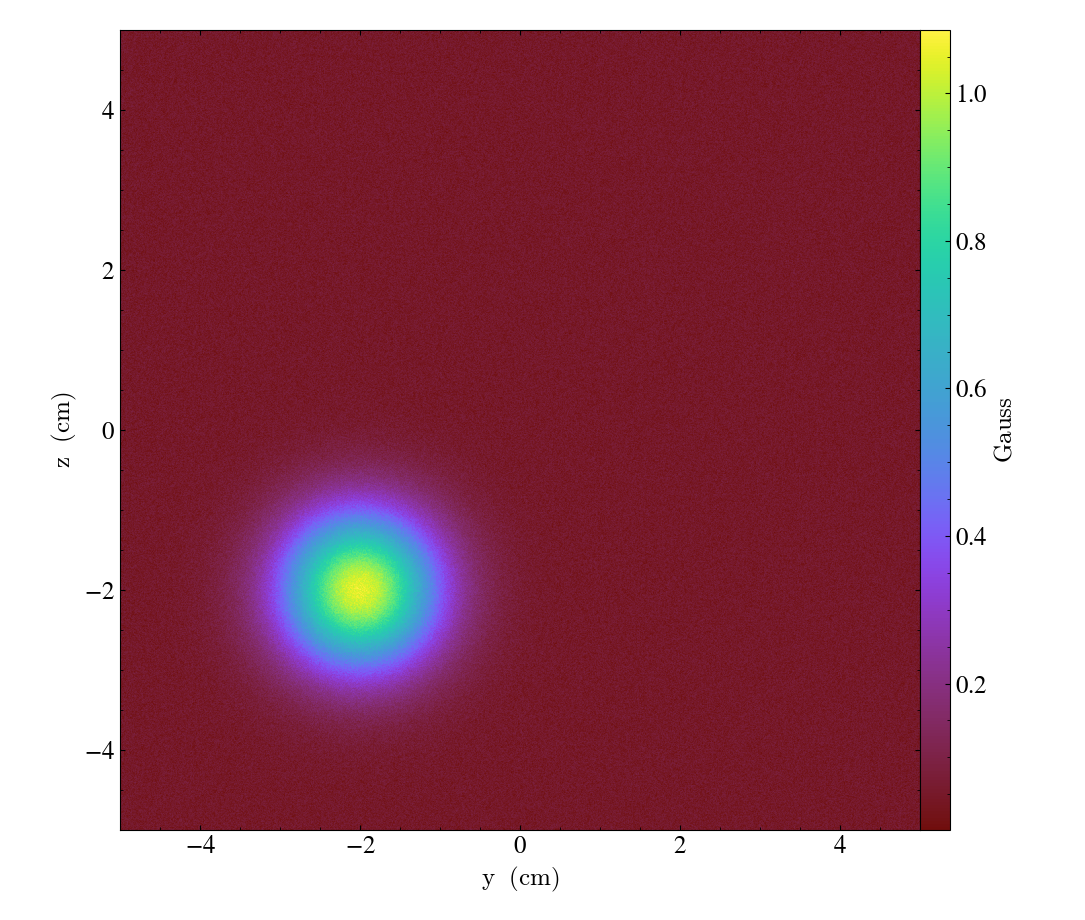

In [33]:
fld = ('stream', "gauss")
ce = ds.domain_center
ce[0] = 3.
slc = yt.SlicePlot(ds, "x", fld, center = ce)
slc.set_log(fld, False)

In [34]:
sp = ds.sphere(ds.arr([3.,3.,3.],'code_length'), 2.)
sp.center

unyt_array([3., 3., 3.], 'code_length')

In [35]:
%%time
sp.quantities.extrema(fld)

CPU times: user 8.83 s, sys: 990 ms, total: 9.82 s
Wall time: 11 s


unyt_array([0.01831734, 1.09936532], '(dimensionless)')

CPU times: user 31 s, sys: 7.48 s, total: 38.5 s
Wall time: 40.9 s



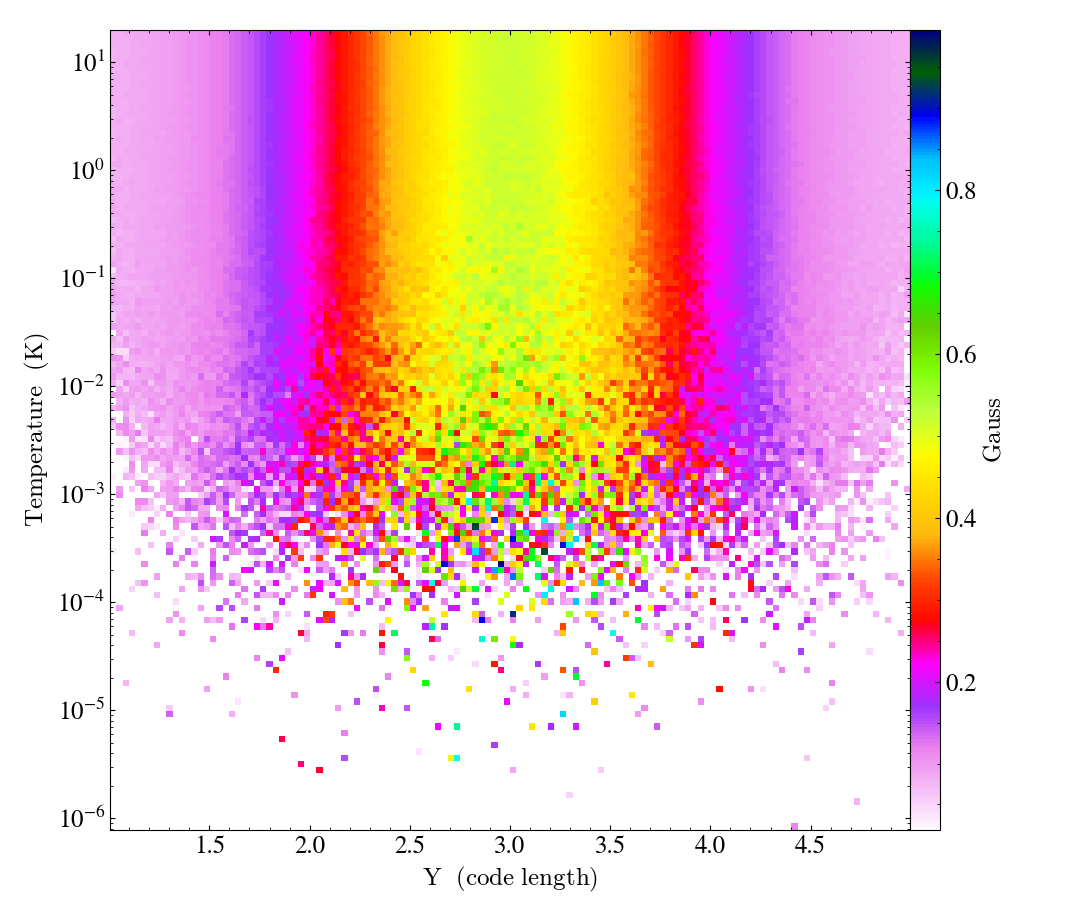

In [37]:
%%time
pp = yt.PhasePlot(sp, ("index", "y"), ("stream", "temperature"), fld, weight_field=fld)
pp.set_cmap(fld, "gist_ncar_r")
pp.set_log(fld, False)

In [36]:
c.close()

# 5. Limitations

So the main limitation to this approach is that the yt data-read is a serial loop over yt grid objects. This means that even if we have a dask cluster with more than one process, we would only ever utilize a single process. This suggests the main advantage of a full xarray frontend (as opposed to a wrapper functions based around `load_amr_grids`): we could over-ride the yt chunk iterations to use dask, similar to the daskified Particle Reader, but within a dask-only xarray frontend, which would limit that scope of any dask functionality **significantly**. 

Note also that there are some processes that do seem to stall and crash -- a projection plot with the larger dataset for example will fail... not sure why as I thought the projection plots would process chunks separately, but it may be related to building arrays for the cell positions. 



# 6. To Do

Would be interesting to:

1. compare an operation in yt to the pure dask-xarray counterpart. finding extrema of all data is an easy comparison that pure dask-xarray will likely have an advantage in. But how about the extrema within some sub-selection? yt might have a bit of an advantage there. 

2. experiment with an xarray frontend that over-rides the chunking framework to send operations to dask. 